In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PV power measurements for Location 1 and 3/Location 1 SBRC/GEN_DATA - Sheet1 - GEN_DATA - Sheet1.csv')

In [ ]:
for i in data.select_dtypes('object').columns:
   le = LabelEncoder().fit(data[i])
   data[i] = le.transform(data[i])

In [ ]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[['Time']])
Y_data = Y_scaler.fit_transform(data[['Generation']])

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y)

In [ ]:
hist_window = 10
horizon = 1
TRAIN_SPLIT = int(len(X_data)*0.7)
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.64      ]
 [0.64266667]
 [0.64533333]
 [0.648     ]
 [0.65066667]
 [0.65333333]
 [0.656     ]
 [0.65866667]
 [0.66133333]
 [0.664     ]]

 Target horizon

[[0.00175308]]


In [ ]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [ ]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True),input_shape=x_train.shape[-2:]),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences= True)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences= True)),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= False)),
  #tf.keras.layers.Dense(8, activation='tanh'),
  tf.keras.layers.Dense(16, activation='tanh'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='tanh'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='tanh'),
  tf.keras.layers.Dense(4, activation='tanh'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 64)           24832     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                        

In [ ]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
#early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[checkpoint] #early_stopings]

In [ ]:
history = lstm_model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 9s 91ms/step - loss: 0.0069 - val_loss: 0.0470
Epoch 2/100
100/100 [==============================] - 9s 86ms/step - loss: 0.0065 - val_loss: 0.0399
Epoch 3/100
100/100 [==============================] - 6s 59ms/step - loss: 0.0065 - val_loss: 0.0421
Epoch 4/100
100/100 [==============================] - 6s 58ms/step - loss: 0.0067 - val_loss: 0.0446
Epoch 5/100
100/100 [==============================] - 6s 62ms/step - loss: 0.0067 - val_loss: 0.0427
Epoch 6/100
100/100 [==============================] - 6s 59ms/step - loss: 0.0065 - val_loss: 0.0408
Epoch 7/100
100/100 [==============================] - 6s 61ms/step - loss: 0.0065 - val_loss: 0.0429
Epoch 8/100
100/100 [==============================] - 6s 57ms/step - loss: 0.0067 - val_loss: 0.0433
Epoch 9/100
100/100 [==============================] - 6s 61ms/step - loss: 0.0065 - val_loss: 0.0417
Epoch 10/100
100/100 [==============================] - 9s 85ms/step - loss: 0.006

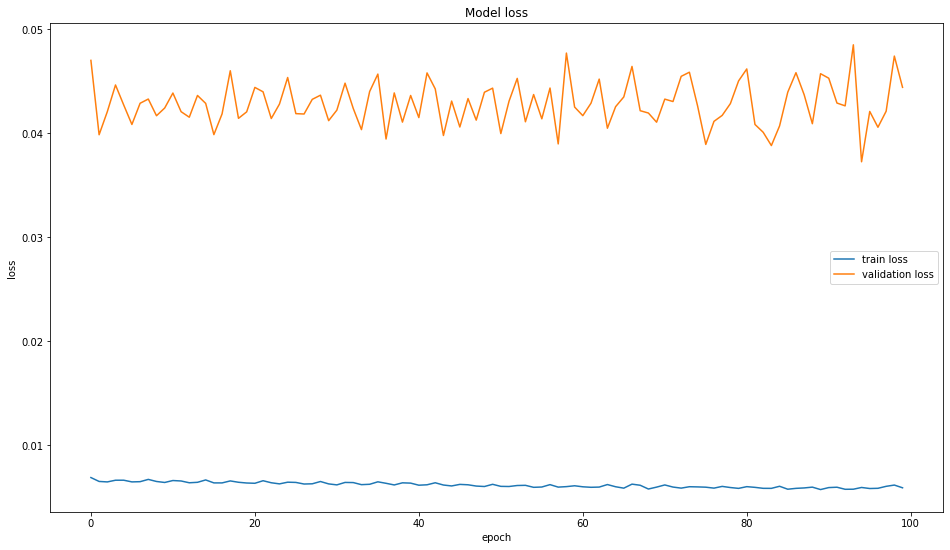

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()


In [ ]:
data_val = X_scaler.fit_transform(data[['Time']].tail(10))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

array([[93.117455]], dtype=float32)

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
     def mean_absolute_percentage_error(y_true, y_pred):
         y_true, y_pred = np.array(y_true), np.array(y_pred)
         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
     print('Evaluation metric results:-')
     print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
     print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
     print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
timeseries_evaluation_metrics_func(validate['Generation'],pred_Inverse[0])

NameError: ignored

In [ ]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['traffic_volume']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()